# Data Analytics Project

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics.cluster as metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense


Step 1: Data preparation, cleansing and visualization.

Import dataset.

In [124]:
data = pd.read_csv('US_Accidents_Dec21_updated.csv')

 After we have successfully read the dataset, it is time to drop all useless columns in order to clean up our data. Effective data cleansing is a vital part of the data analysis process, ensuring that the dataset is accurate and up-to-date.
The columns that we have decided to drop are listed below:
- Nautical_Twilight, Astronomical_Twilight, Civil_Twilight (information similar to Sunrise_Sunset column),
- End_Time (it seems that the end time of every accident is approximately six hours later from the start time),
- Number (this column contains a large amount of null values),
- Description (the information given by this column is, usually, given by other columns as well)

In [125]:
data = data.drop(columns=['Nautical_Twilight','Astronomical_Twilight','Civil_Twilight','End_Time','Number','Description'])

Convert Start_time to datetime data type.

In [126]:
data.Start_Time = pd.to_datetime(data.Start_Time)

# Print first five rows of dataset
data.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Street,Side,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,A-1,3,2016-02-08 00:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Outerbelt E,R,...,False,False,False,False,False,False,False,False,False,Night
1,A-2,2,2016-02-08 05:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,I-70 E,R,...,False,False,False,False,False,False,False,False,False,Night
2,A-3,2,2016-02-08 06:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,I-75 S,R,...,True,False,False,False,False,False,False,False,False,Night
3,A-4,2,2016-02-08 06:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,I-77 N,R,...,False,False,False,False,False,False,False,False,False,Night
4,A-5,3,2016-02-08 07:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,I-75 S,R,...,False,False,False,False,False,False,False,False,False,Day


Dimensionality of dataset.

In [127]:
data.shape

(2845342, 41)

Understand the data (view datatypes, columns etc).

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 41 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ID                 object        
 1   Severity           int64         
 2   Start_Time         datetime64[ns]
 3   Start_Lat          float64       
 4   Start_Lng          float64       
 5   End_Lat            float64       
 6   End_Lng            float64       
 7   Distance(mi)       float64       
 8   Street             object        
 9   Side               object        
 10  City               object        
 11  County             object        
 12  State              object        
 13  Zipcode            object        
 14  Country            object        
 15  Timezone           object        
 16  Airport_Code       object        
 17  Weather_Timestamp  object        
 18  Temperature(F)     float64       
 19  Wind_Chill(F)      float64       
 20  Humidity(%)        float

Drop null values in order to clean the data even more.

In [129]:
# See how many null values are there in each column
data.isna().sum()

# Drop null values
data= data.dropna()

Dimensionality of dataset (for comparative purpose only, see code cell 5).

In [130]:
data.shape

(2207325, 41)

Cleaning up Weather_Condition column:

The Weather_Condition column has the highest correlation with the severity column. It also has a lot of unique values that don't appear often. As a result of the above, we decided to clean this feature up, to minimize the number of values that the Weather_Condition column has.

First round of clean up.

<AxesSubplot:ylabel='Weather_Condition'>

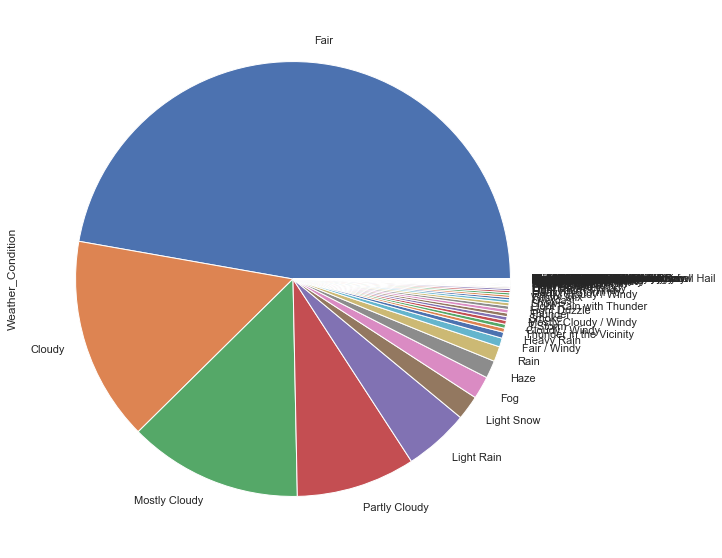

In [131]:
# Before clean up
data.Weather_Condition.value_counts().plot(kind='pie',figsize=(10,10))

In [132]:
# Sort values into general weather categories
data.loc[data.Weather_Condition.str.contains('Clear'),'Weather_Condition'] = 'Fair'
data.loc[data.Weather_Condition.str.contains('Sleet'),'Weather_Condition'] = 'Hail'
data.loc[data.Weather_Condition.str.contains('Ice Pellets'),'Weather_Condition'] = 'Hail'
data.loc[data.Weather_Condition.str.contains('Sand'),'Weather_Condition'] = 'Dusty'
data.loc[data.Weather_Condition.str.contains('Dust'),'Weather_Condition'] = 'Dusty'
data.loc[data.Weather_Condition.str.contains('Drizzle'),'Weather_Condition'] = 'Rain'
data.loc[data.Weather_Condition.str.contains('T-Storm'),'Weather_Condition'] = 'Thunderstorms'
data.loc[data.Weather_Condition.str.contains('Thunder'),'Weather_Condition'] = 'Thunderstorms'
data.loc[data.Weather_Condition.str.contains('Fog'),'Weather_Condition'] = 'Fog'
data.loc[data.Weather_Condition.str.contains('Cloud'),'Weather_Condition'] = 'Cloudy'
data.loc[data.Weather_Condition.str.contains('Rain'),'Weather_Condition'] = 'Rain'
data.loc[data.Weather_Condition.str.contains('Snow'),'Weather_Condition'] = 'Snow'
data.loc[data.Weather_Condition.str.contains('Windy'),'Weather_Condition'] = 'Windy'

<AxesSubplot:ylabel='Weather_Condition'>

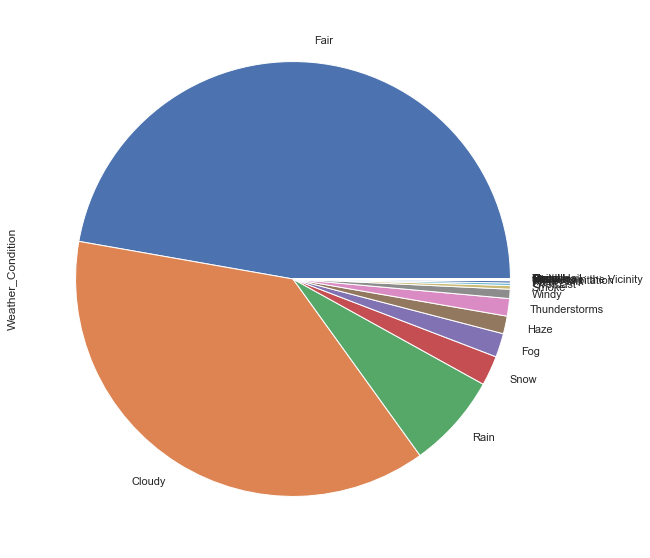

In [133]:
# After clean up
data.Weather_Condition.value_counts().plot(kind='pie',figsize=(10,10))

Second round of clean up.

In [134]:
# Another round of cleaning up this feature
data=data[(data.Weather_Condition == 'Fair') | (data.Weather_Condition == 'Mostly Cloudy') | (data.Weather_Condition == 'Cloudy') | (data.Weather_Condition == 'Partly Cloudy') | (data.Weather_Condition == 'Clear') | 
(data.Weather_Condition == 'Light Rain') | (data.Weather_Condition == 'Overcast') | (data.Weather_Condition == 'Scattered Clouds') | (data.Weather_Condition == 'Light Snow') | (data.Weather_Condition == 'Fog') | 
(data.Weather_Condition == 'Haze') | (data.Weather_Condition == 'Rain') | (data.Weather_Condition == 'Fair/Windy')]

<AxesSubplot:ylabel='Weather_Condition'>

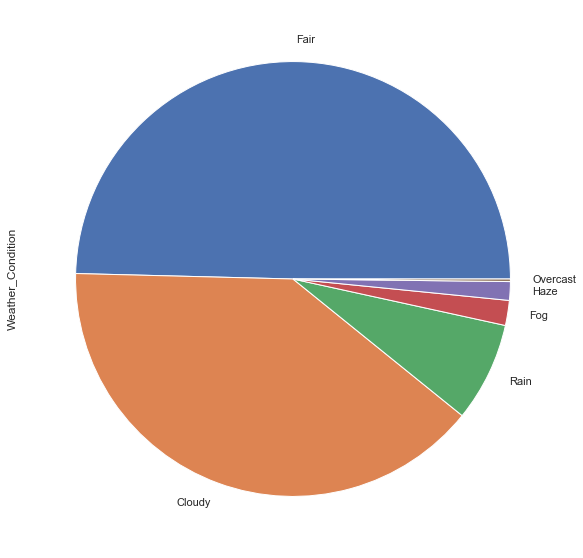

In [135]:
data.Weather_Condition.value_counts().plot(kind='pie',figsize=(10,10))

Print statistic data for each arithmetic feature.

In [136]:
data.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06,2.101929e+06
mean,2.072569e+00,3.587314e+01,-9.672859e+01,3.587328e+01,-9.672832e+01,6.776976e-01,6.255000e+01,6.162088e+01,6.416557e+01,2.940105e+01,9.231672e+00,6.926737e+00,4.366104e-03
std,3.795681e-01,5.393932e+00,1.834432e+01,5.394036e+00,1.834408e+01,1.438928e+00,1.779366e+01,1.941785e+01,2.261024e+01,1.046924e+00,2.366669e+00,5.190876e+00,4.919809e-02
min,1.000000e+00,2.456603e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-3.300000e+01,-5.010000e+01,1.000000e+00,1.672000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.292400e+01,-1.180044e+02,3.292392e+01,-1.180037e+02,4.500000e-02,5.000000e+01,5.000000e+01,4.800000e+01,2.923000e+01,1.000000e+01,3.000000e+00,0.000000e+00
50%,2.000000e+00,3.539927e+01,-9.103596e+01,3.539954e+01,-9.103523e+01,2.040000e-01,6.400000e+01,6.400000e+01,6.600000e+01,2.975000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,3.991150e+01,-8.033532e+01,3.991000e+01,-8.033562e+01,7.660000e-01,7.600000e+01,7.600000e+01,8.300000e+01,2.997000e+01,1.000000e+01,1.000000e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.748413e+01,4.907500e+01,-6.748413e+01,1.551860e+02,1.960000e+02,1.960000e+02,1.000000e+02,5.890000e+01,1.000000e+02,1.087000e+03,2.400000e+01


Statistic number of accidents per state.

<AxesSubplot:ylabel='State'>

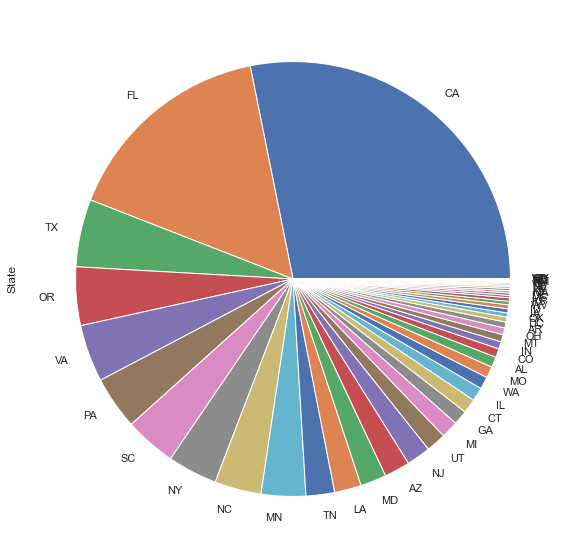

In [137]:
data.State.value_counts().plot(kind='pie', figsize=(10,10))

Statistic severity of accidents.

<AxesSubplot:ylabel='Severity'>

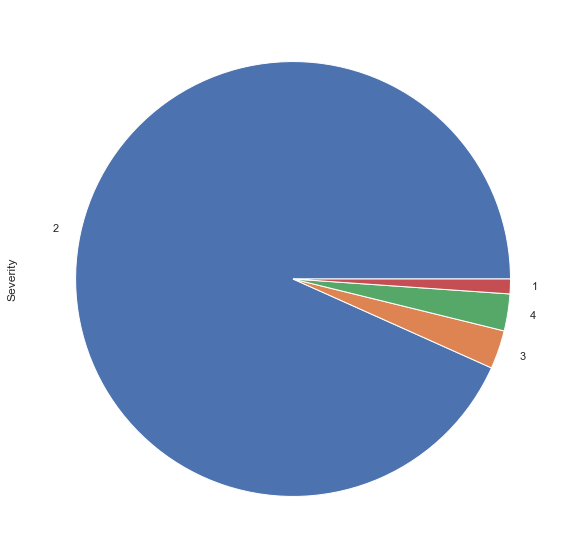

In [138]:
data.Severity.value_counts().plot(kind='pie',figsize=(10,10))

Accident's map given that longitute and langitute.

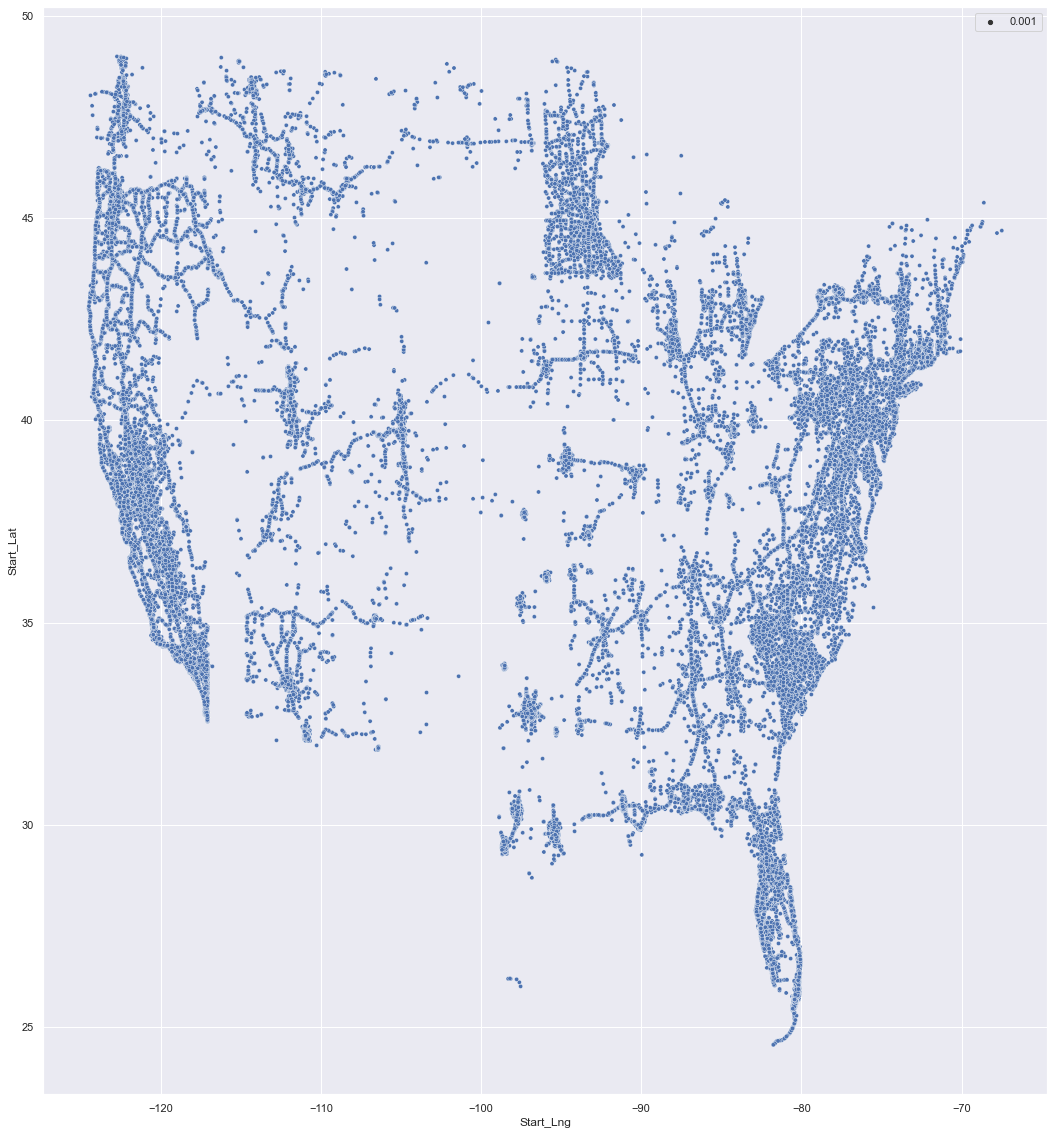

In [145]:
sample_df = data.sample(int(0.1 * len(data)))
sns.scatterplot(x=sample_df.Start_Lng, y=sample_df.Start_Lat, size=0.001)
sns.set(rc={"figure.figsize":(13, 20)})

Correlation.

In [146]:
data.corr()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Severity,1.000000,0.084747,0.090828,0.084750,0.090831,0.059298,-0.029568,-0.032065,0.028896,-0.042994,...,0.006578,0.040396,-0.003868,-0.001697,-0.001107,-0.014516,-0.001634,-0.001878,-0.009910,NaN
Start_Lat,0.084747,1.000000,-0.180964,0.999996,-0.180960,0.075544,-0.462861,-0.468223,-0.024004,-0.290402,...,0.012208,0.061543,-0.018014,0.002342,-0.005555,-0.121633,0.012265,-0.002728,-0.055370,NaN
Start_Lng,0.090828,-0.180964,1.000000,-0.180961,0.999999,0.038353,0.058058,0.043426,0.162430,0.225997,...,0.016832,-0.026095,0.004699,-0.016933,0.001381,0.042311,-0.045541,-0.009500,0.059222,NaN
End_Lat,0.084750,0.999996,-0.180961,1.000000,-0.180957,0.075529,-0.462856,-0.468218,-0.024009,-0.290404,...,0.012194,0.061529,-0.018012,0.002342,-0.005555,-0.121631,0.012275,-0.002728,-0.055372,NaN
End_Lng,0.090831,-0.180960,0.999999,-0.180957,1.000000,0.038356,0.058062,0.043429,0.162425,0.225999,...,0.016831,-0.026090,0.004699,-0.016933,0.001381,0.042310,-0.045540,-0.009500,0.059219,NaN
Distance(mi),0.059298,0.075544,0.038353,0.075529,0.038356,1.000000,-0.037084,-0.040191,0.016258,-0.066651,...,-0.007292,0.031190,-0.011055,-0.023468,-0.002730,-0.058181,-0.032776,-0.008109,-0.112272,NaN
Temperature(F),-0.029568,-0.462861,0.058058,-0.462856,0.058062,-0.037084,1.000000,0.994450,-0.353158,0.144717,...,-0.008291,-0.034139,0.011813,0.002701,0.002509,0.069178,-0.001475,0.005673,0.041686,NaN
Wind_Chill(F),-0.032065,-0.468223,0.043426,-0.468218,0.043429,-0.040191,0.994450,1.000000,-0.336111,0.153995,...,-0.008460,-0.034099,0.011541,0.003403,0.002507,0.067878,-0.000523,0.005893,0.041212,NaN
Humidity(%),0.028896,-0.024004,0.162430,-0.024009,0.162425,0.016258,-0.353158,-0.336111,1.000000,0.187201,...,-0.000576,0.008684,-0.007910,0.000624,0.001009,0.000819,-0.015829,-0.006583,-0.032463,NaN
Pressure(in),-0.042994,-0.290402,0.225997,-0.290404,0.225999,-0.066651,0.144717,0.153995,0.187201,1.000000,...,-0.002578,0.021621,-0.001152,0.017527,0.001084,0.050820,-0.012817,0.000237,0.017394,NaN


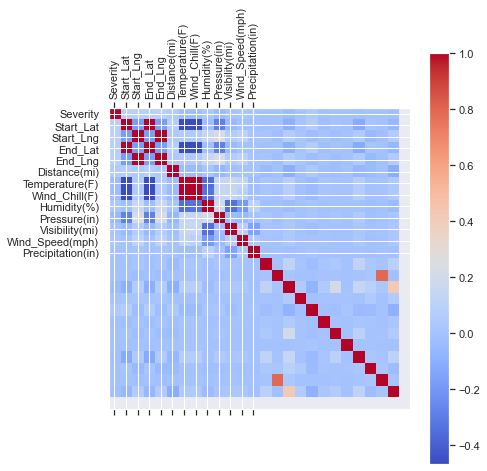

In [147]:

fig, ax = plt.subplots(1,1, figsize=(7,7))
sm = ax.matshow(data.corr(), cmap='coolwarm')

plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, rotation=90, ha='center')
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, )

plt.colorbar(sm)

plt.tight_layout()
plt.savefig('corrmap.png', dpi=300)
plt.show()

Covariance.

In [148]:
data.cov()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Severity,0.144072,0.173508,0.632425,0.173516,0.632439,0.032387,-0.199698,-0.236332,0.247991,-0.017085,...,1.229311e-04,4.227623e-03,-5.951074e-05,-5.822264e-05,-2.838624e-06,-8.958309e-04,-0.000086,-1.861905e-05,-0.001119,0.0
Start_Lat,0.173508,29.094501,-17.906050,29.094941,-17.905388,0.586332,-44.424350,-49.040974,-2.927446,-1.639912,...,3.241907e-03,9.152761e-02,-3.938906e-03,1.141847e-03,-2.024829e-04,-1.066723e-01,0.009203,-3.843086e-04,-0.088847,0.0
Start_Lng,0.632425,-17.906050,336.514002,-17.906064,336.509337,1.012382,18.950953,15.468511,67.370953,4.340297,...,1.520093e-02,-1.319849e-01,3.494150e-03,-2.807507e-02,1.712338e-04,1.261985e-01,-0.116216,-4.551846e-03,0.323177,0.0
End_Lat,0.173516,29.094941,-17.906064,29.095626,-17.905425,0.586228,-44.424736,-49.041479,-2.928178,-1.639956,...,3.238292e-03,9.150827e-02,-3.938606e-03,1.141564e-03,-2.024903e-04,-1.066729e-01,0.009211,-3.842957e-04,-0.088852,0.0
End_Lng,0.632439,-17.905388,336.509337,-17.905425,336.505147,1.012440,18.951780,15.469420,67.368143,4.340276,...,1.520067e-02,-1.319563e-01,3.494111e-03,-2.807474e-02,1.712229e-04,1.261941e-01,-0.116214,-4.551652e-03,0.323160,0.0
Distance(mi),0.032387,0.586332,1.012382,0.586228,1.012440,2.070513,-0.949483,-1.122969,0.528938,-0.100406,...,-5.165785e-04,1.237415e-02,-6.448583e-04,-3.052125e-03,-2.654371e-05,-1.361180e-02,-0.006561,-3.047688e-04,-0.048058,0.0
Temperature(F),-0.199698,-44.424350,18.950953,-44.424736,18.951780,-0.949483,316.614429,343.597011,-142.082079,2.695877,...,-7.263451e-03,-1.674874e-01,8.520796e-03,4.343655e-03,3.017230e-04,2.001384e-01,-0.003651,2.636603e-03,0.220656,0.0
Wind_Chill(F),-0.236332,-49.040974,15.468511,-49.041479,15.469420,-1.122969,343.597011,377.053068,-147.566908,3.130560,...,-8.087112e-03,-1.825608e-01,9.084831e-03,5.973055e-03,3.289340e-04,2.143005e-01,-0.001412,2.988799e-03,0.238060,0.0
Humidity(%),0.247991,-2.927446,67.370953,-2.928178,67.368143,0.528938,-142.082079,-147.566908,511.222944,4.431285,...,-6.411079e-04,5.413428e-02,-7.249949e-03,1.274305e-03,1.541943e-04,3.012002e-03,-0.049788,-3.887665e-03,-0.218348,0.0
Pressure(in),-0.017085,-1.639912,4.340297,-1.639956,4.340276,-0.100406,2.695877,3.130560,4.431285,1.096051,...,-1.328945e-04,6.241160e-03,-4.888906e-05,1.658492e-03,7.668659e-06,8.650658e-03,-0.001867,6.484434e-06,0.005417,0.0


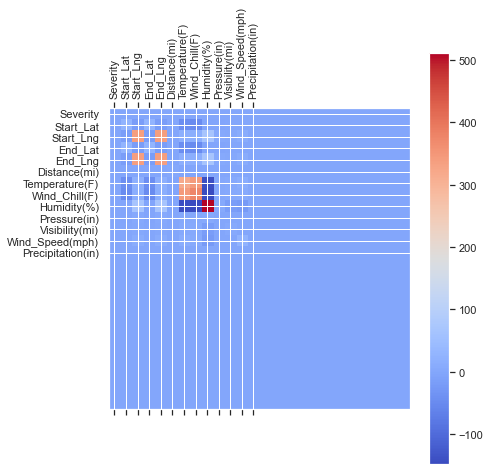

In [149]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sm = ax.matshow(data.cov(), cmap='coolwarm')

plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, rotation=90, ha='center')
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, )

plt.colorbar(sm)

plt.tight_layout()
plt.savefig('covmap.png', dpi=300)
plt.show()

Scaling & Normalization.

In [150]:
# Counting the numerical colmns in the dataset
numeric = ['int16','int32','int64','float16','float32','float64']
numeric_columns = data.select_dtypes(include=numeric)
numeric_columns.head()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,3,40.108910,-83.092860,40.112060,-83.031870,3.230,42.1,36.1,58.0,29.76,10.0,10.4,0.00
4,3,39.172393,-84.492792,39.170476,-84.501798,0.500,37.0,29.8,93.0,29.69,10.0,10.4,0.01
56,2,38.178100,-85.719460,38.181040,-85.721160,0.223,17.1,5.8,68.0,30.12,10.0,9.2,0.00
57,2,38.185770,-85.806780,38.206480,-85.827850,1.832,17.1,5.8,68.0,30.12,10.0,9.2,0.00
58,3,38.271910,-85.808380,38.271910,-85.808380,0.000,17.1,5.8,68.0,30.12,10.0,9.2,0.00


In [151]:
# Initialize a minmax scaler 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# Scale the dataframe
df_scaled = scaler.fit_transform(numeric_columns.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'])
df_scaled.head()


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,0.666667,0.636103,0.726469,0.634300,0.727527,0.020814,0.327948,0.350264,0.575758,0.309151,0.1,0.009568,0.000000
1,0.666667,0.597775,0.701937,0.595882,0.701767,0.003222,0.305677,0.324665,0.929293,0.307492,0.1,0.009568,0.000417
2,0.333333,0.557083,0.680440,0.555512,0.680398,0.001437,0.218777,0.227143,0.676768,0.317686,0.1,0.008464,0.000000
3,0.333333,0.557397,0.678910,0.556550,0.678528,0.011805,0.218777,0.227143,0.676768,0.317686,0.1,0.008464,0.000000
4,0.666667,0.560922,0.678882,0.559219,0.678869,0.000000,0.218777,0.227143,0.676768,0.317686,0.1,0.008464,0.000000


Binarize boolean values.

In [152]:
bool_type = ['bool']
bool_columns = data.select_dtypes(include=bool_type)
bool_columns.head()

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
56,False,False,False,False,False,False,False,False,False,False,False,False,False
57,False,False,False,False,False,False,False,False,False,False,False,False,False
58,False,False,False,False,False,False,False,False,False,False,False,False,False


In [153]:
# Convert boolean DataFrame to binary number array
bool_columns = bool_columns.astype(int)
bool_columns.head()

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,0,0,0
57,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,0,0,0


Binarize Sunrise_Sunset column.

In [154]:
sun_column = data["Sunrise_Sunset"]
sun_column = label_binarize(sun_column.array, classes=['Day', 'Night'])
sun_column = pd.DataFrame(sun_column, columns=['Sunrise_Sunset'])
sun_column.head()

,Sunrise_Sunset
0,1
1,0
2,0
3,0
4,0


Binarize Side column.

In [155]:
side_column = data["Side"]
side_column = label_binarize(side_column.array, classes=['R', 'L'])
side_column = pd.DataFrame(side_column, columns=['Side'])
side_column.head()

,Side
0,0
1,0
2,0
3,0
4,0


Concatenate:
- df_scaled dataframe
- sun_column dataframe
- side_column dataframe
- bool_columns dataframe

In [156]:
# Reset indexed (this action will prevent the appearance of NaN values while concatenating)
sun_column.reset_index(drop=True, inplace=True)
side_column.reset_index(drop=True, inplace=True)
bool_columns.reset_index(drop=True, inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

In [157]:
# Concatenating
dframes = [df_scaled, side_column, sun_column, bool_columns]
scaled_data = pd.concat(dframes, axis=1)
scaled_data.head()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,0.666667,0.636103,0.726469,0.634300,0.727527,0.020814,0.327948,0.350264,0.575758,0.309151,...,0,0,0,0,0,0,0,0,0,0
1,0.666667,0.597775,0.701937,0.595882,0.701767,0.003222,0.305677,0.324665,0.929293,0.307492,...,0,0,0,0,0,0,0,0,0,0
2,0.333333,0.557083,0.680440,0.555512,0.680398,0.001437,0.218777,0.227143,0.676768,0.317686,...,0,0,0,0,0,0,0,0,0,0
3,0.333333,0.557397,0.678910,0.556550,0.678528,0.011805,0.218777,0.227143,0.676768,0.317686,...,0,0,0,0,0,0,0,0,0,0
4,0.666667,0.560922,0.678882,0.559219,0.678869,0.000000,0.218777,0.227143,0.676768,0.317686,...,0,0,0,0,0,0,0,0,0,0


In [158]:
scaled_data.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Side', 'Sunrise_Sunset', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'],
      dtype='object')

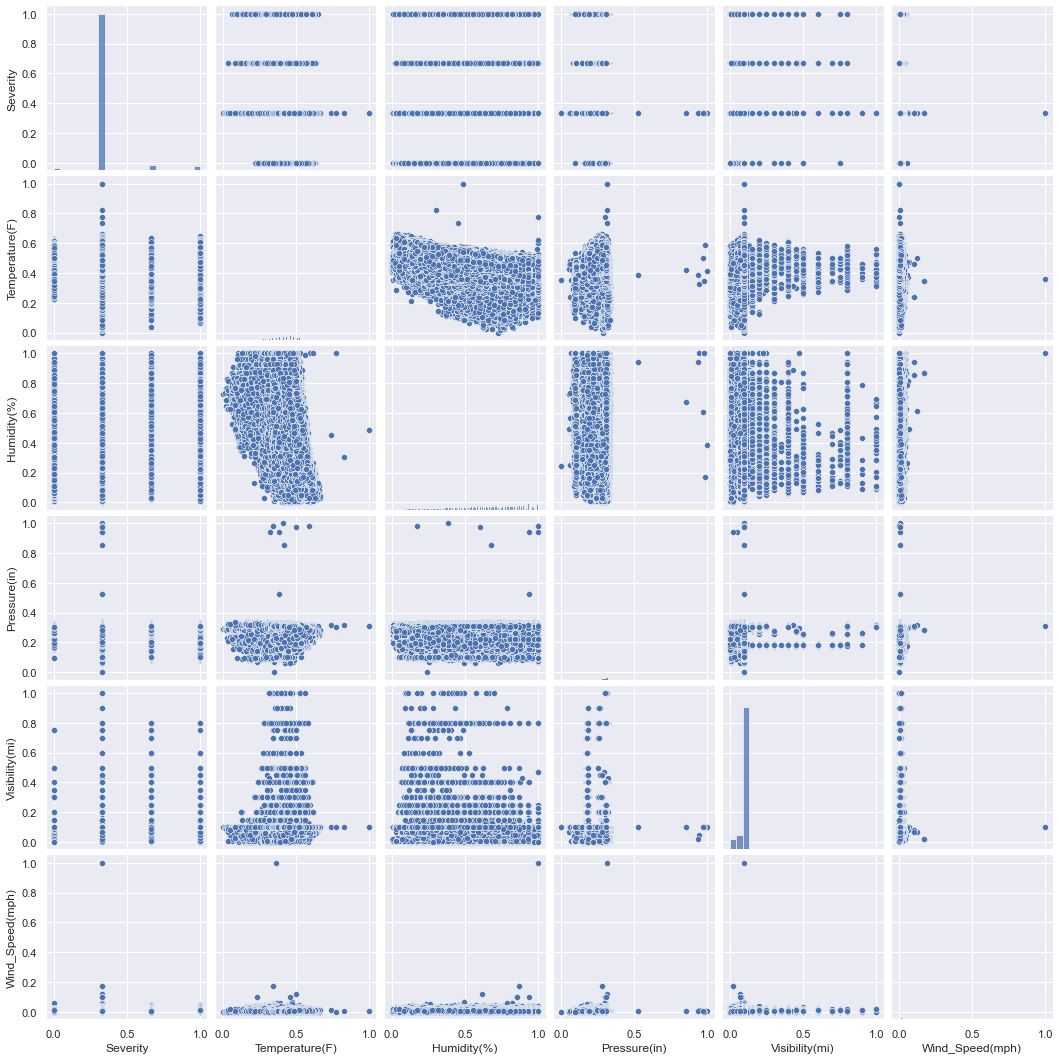

In [228]:
sns.pairplot(
    scaled_data[['Severity','Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']])

# Clustering

Split dataset into test set and training set for Κ-means.

In [160]:
y = scaled_data["Severity"]
x = scaled_data.drop("Severity", axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y)

Kmeans

In [161]:
kmeans = cluster.MiniBatchKMeans(n_clusters=5,init='k-means++')
kmeans = kmeans.fit(x_train, y_train) # Actual
prediction = kmeans.predict(x_test, y_test) # Predicted

K-means Metrics Score

In [162]:
correct = np.round(y_test.to_numpy())
metrics.accuracy_score(correct, prediction)

0.19197956927245982

Visualization of Kmeans clustering.

1. Scatterplot

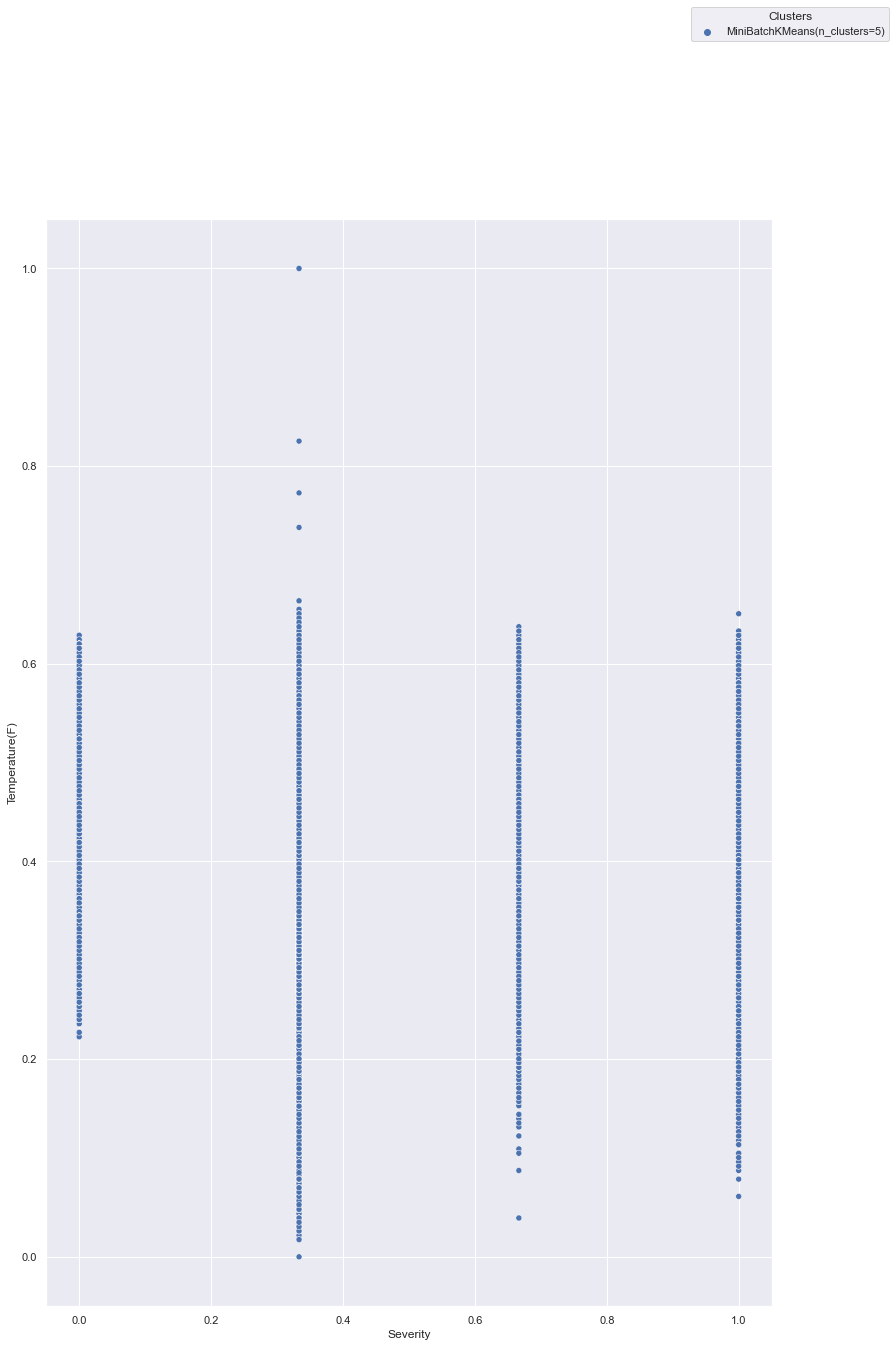

In [163]:
# Scatterplot combining Severity and Temperature features
p = sns.scatterplot(x=scaled_data['Severity'], y=scaled_data['Temperature(F)'], hue = kmeans, legend = "full", data = scaled_data)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
sns.set(rc={"figure.figsize":(10, 10)})
plt.show()

2. Confusion Matrix

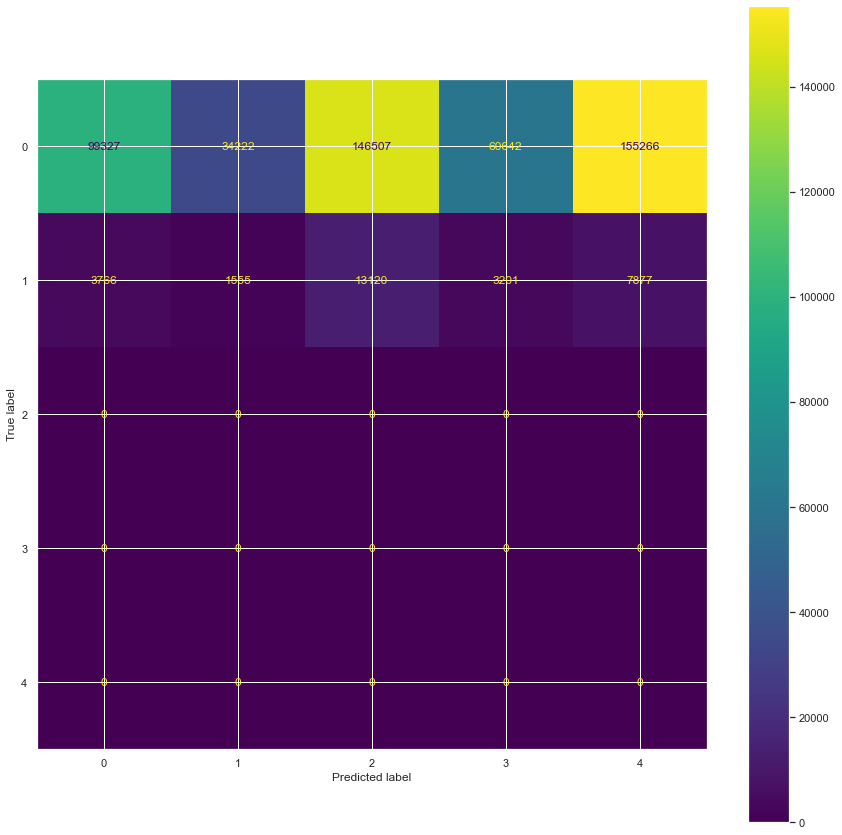

In [164]:
cm = confusion_matrix(correct, prediction)
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax = ax)

For the next two clustering methods we will reduce the size of the dataset in order to speed up execution time.

In [165]:
scaled_data.shape

(2101929, 28)

In [166]:
# We will reduce the size of the dataset in order to speed up execution time
asda = scaled_data.loc[1:5000, :]
asda.shape

(5000, 28)

Split reduced dataset into test set and training set for DBSCAN and OPTICS.

In [167]:
y2 = asda["Severity"]
x2 = asda.drop("Severity", axis = 1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2)

DBSCAN

In [168]:
db = cluster.DBSCAN(eps=0.3, min_samples=10)
label = db.fit(x_train2, y_train2)

In [169]:
# Cluster labels
labels = db.labels_
prediction = db.fit_predict(x_test2, y_test2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 15
Estimated number of noise points: 350


Metrics Accuracy

In [170]:
correct = np.round(y_test2.to_numpy())
metrics.accuracy_score(correct, prediction)

0.1288

Visualization of DBSCAN clustering.

1. Scatterplot

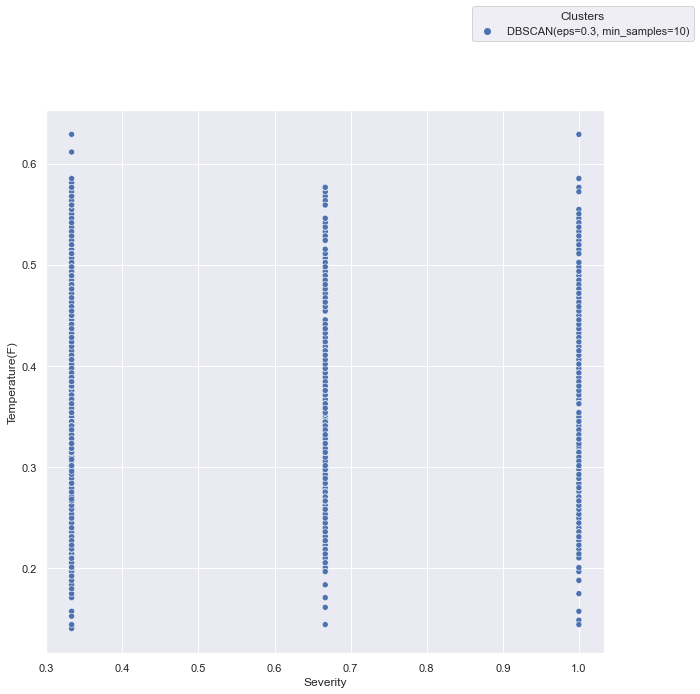

In [171]:
# Scatterplot combining Severity and Temperature features
p = sns.scatterplot(x=asda['Severity'], y=asda['Temperature(F)'], hue = label, legend = "full", data = asda)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
sns.set(rc={"figure.figsize":(20, 20)})
plt.show()

2. Confusion Matrix

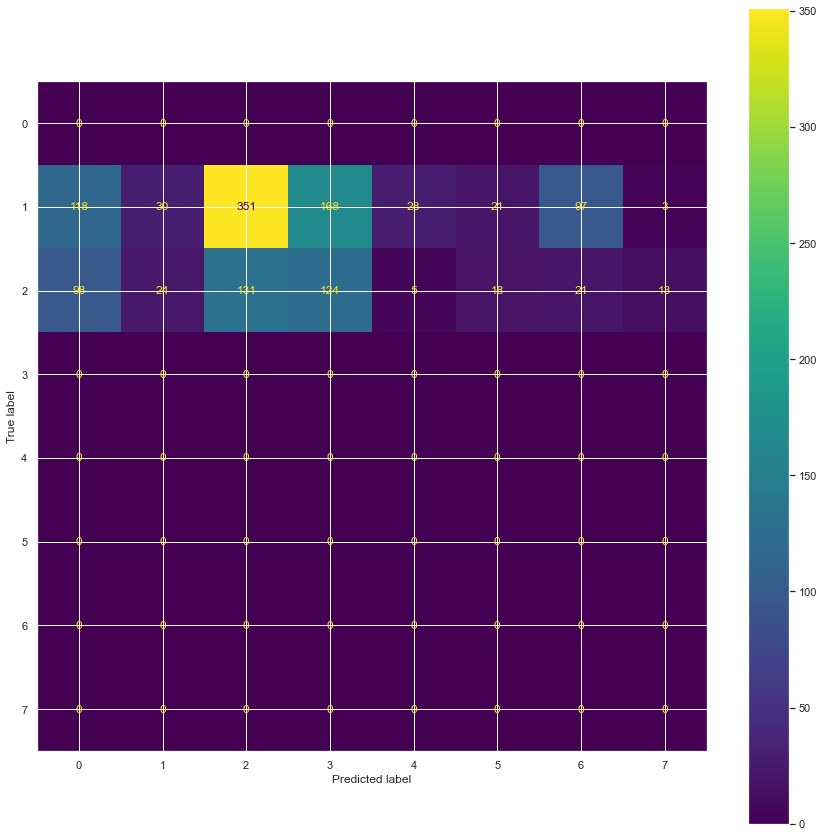

In [172]:
cm = confusion_matrix(correct, prediction)
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax = ax)

OPTICS

In [173]:
opt = cluster.OPTICS(min_samples=10)
lab_op = opt.fit(x_train2, y_train2)

In [174]:
# Cluster labels
labels = opt.labels_
prediction = opt.fit_predict(x_test2, y_test2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 68
Estimated number of noise points: 2321


Metrics Accuracy

In [175]:
correct = np.round(y_test2.to_numpy())
metrics.accuracy_score(correct, prediction)

0.0152

Visualization of OPTICS clustering.

1. Scatterplot

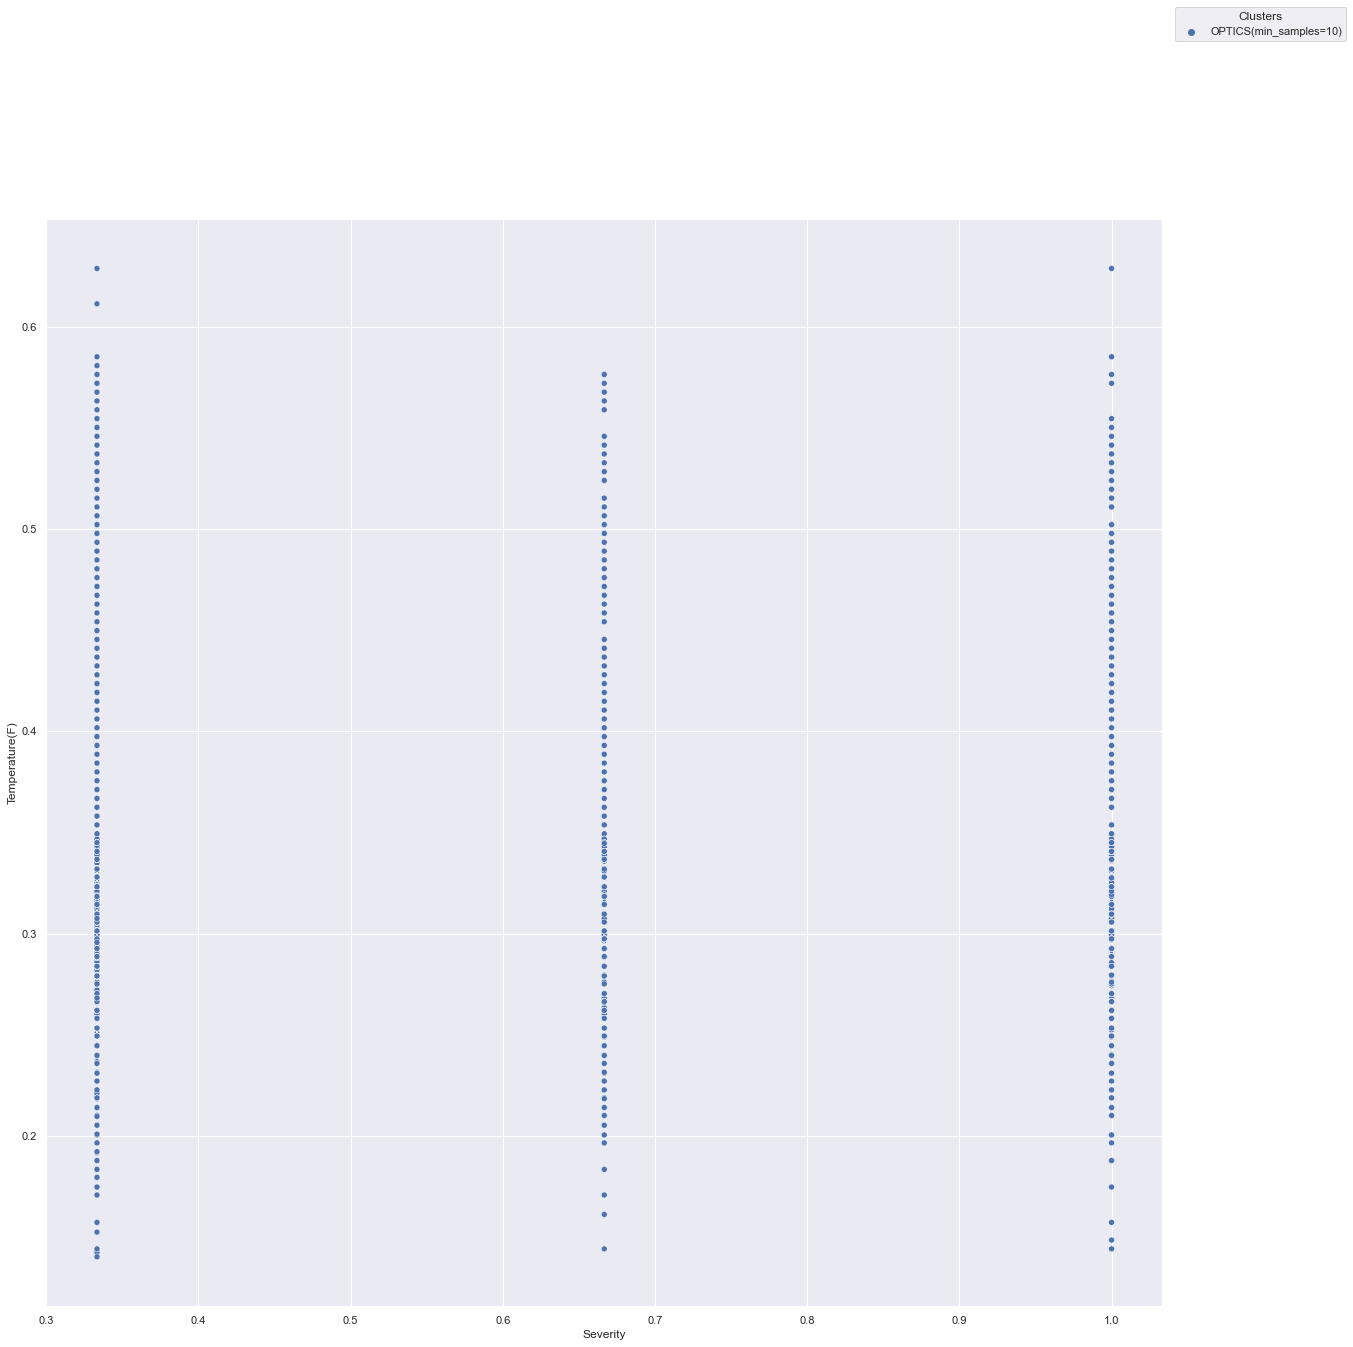

In [176]:
# Scatterplot combining Severity and Temperature features
p = sns.scatterplot(x=asda['Severity'], y=asda['Temperature(F)'], hue = lab_op, legend = "full", data = asda)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
sns.set(rc={"figure.figsize":(10, 10)})
plt.show()

2. Confusion Matrix

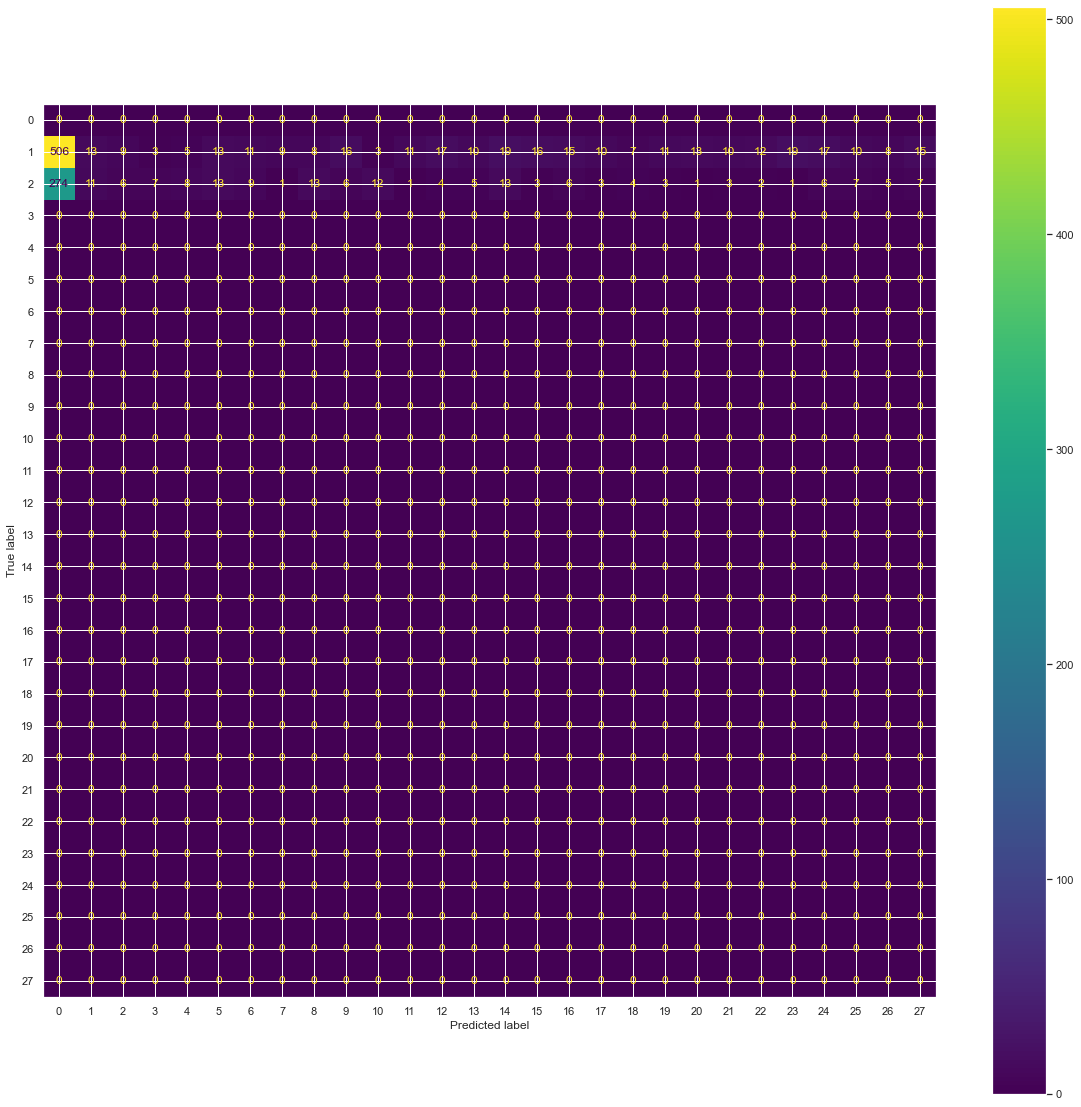

In [177]:
cm = confusion_matrix(correct, prediction)
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax = ax)

# Machine Learning Models

1. Basic Linear Regression

In [178]:
# Split the asda dataset into a training set and a test set
train_dataset = asda.sample(frac=0.8, random_state=0)
test_dataset = asda.drop(train_dataset.index)


In [179]:
# Statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Severity,4000.0,0.519083,0.261486,0.333333,0.333333,0.333333,0.666667,1.000000
Start_Lat,4000.0,0.605262,0.179707,0.073604,0.461680,0.655180,0.715567,1.000000
Start_Lng,4000.0,0.587954,0.285900,0.007685,0.478033,0.647056,0.826129,0.982199
End_Lat,4000.0,0.603439,0.179156,0.073381,0.459825,0.653280,0.713257,1.000000
End_Lng,4000.0,0.587951,0.285906,0.007644,0.478088,0.647042,0.825908,0.983457
Distance(mi),4000.0,0.006999,0.017458,0.000000,0.001263,0.002971,0.005969,0.418472
Temperature(F),4000.0,0.340425,0.076854,0.140175,0.292576,0.323144,0.349345,0.628821
Wind_Chill(F),4000.0,0.365044,0.085329,0.135717,0.314100,0.346201,0.390492,0.654612
Humidity(%),4000.0,0.787192,0.197731,0.050505,0.696970,0.858586,0.929293,1.000000
Pressure(in),4000.0,0.305173,0.024388,0.090090,0.302750,0.310811,0.316027,0.337364


In [180]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Severity')
test_labels = test_features.pop('Severity')

In [181]:
# Display ranges for each feature
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Severity,0.519083,0.261486
Start_Lat,0.605262,0.179707
Start_Lng,0.587954,0.285900
End_Lat,0.603439,0.179156
End_Lng,0.587951,0.285906
Distance(mi),0.006999,0.017458
Temperature(F),0.340425,0.076854
Wind_Chill(F),0.365044,0.085329
Humidity(%),0.787192,0.197731
Pressure(in),0.305173,0.024388


In [182]:
# Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features)) # Fit the state of the preprocessing layer to the data
print(normalizer.mean.numpy())

[[6.0526234e-01 5.8795464e-01 6.0343885e-01 5.8795089e-01 6.9989180e-03
  3.4042531e-01 3.6504441e-01 7.8719199e-01 3.0517253e-01 7.2088763e-02
  8.9507392e-03 1.8398957e-03 1.0374998e-01 3.7674996e-01 7.2499979e-03
  0.0000000e+00 3.2250002e-02 3.2499998e-03 2.0674999e-01 7.4999989e-04
  9.9999961e-03 0.0000000e+00 1.1500001e-02 8.4999995e-03 2.5000001e-04
  6.5250009e-02 0.0000000e+00]]


In [183]:
first = np.array(train_features[:1])

# Each feature is independently normalized
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[0.7  0.59 0.7  0.59 0.   0.28 0.32 0.88 0.32 0.03 0.   0.   0.   1.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]

Normalized: [[ 0.52 -0.01  0.52 -0.01 -0.3  -0.74 -0.58  0.46  0.66 -1.44 -0.87 -0.01
  -0.34  1.29 -0.09  0.   -0.18 -0.06 -0.51 -0.03 -0.1   0.   -0.11 -0.09
  -0.02 -0.26  0.  ]]


In [184]:
# We will predict Severity from Visibility
visibility = np.array(train_features['Visibility(mi)'])
visibility_normalizer = layers.Normalization(input_shape=[1,], axis=None)
visibility_normalizer.adapt(visibility)

In [185]:
# Keras Sequential Model
visibility_model = tf.keras.Sequential([
    visibility_normalizer,
    layers.Dense(units=1)
])

visibility_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [186]:
# Run untrained model in oreder fot it to be tested
visibility_model.predict(visibility[:10])

1/1 [==============================] - 0s 61ms/step


array([[ 0.11528318],
       [ 0.11528318],
       [ 0.10304212],
       [-0.06833257],
       [-0.04385047],
       [-0.06833257],
       [-0.06833257],
       [-0.06833257],
       [-0.06833257],
       [-0.06833257]], dtype=float32)

In [187]:
# Compile visibility model
visibility_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [188]:
# Training visibility model
history = visibility_model.fit(
    train_features['Visibility(mi)'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

In [189]:
# Loss statistics
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.194612,0.201917,95
96,0.199471,0.199813,96
97,0.192376,0.216302,97
98,0.195366,0.207403,98
99,0.194211,0.203670,99


In [190]:
# Viualize loss statistics
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.15, 0.3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

Basic Linear Regression Visualization

1. Loss Plot

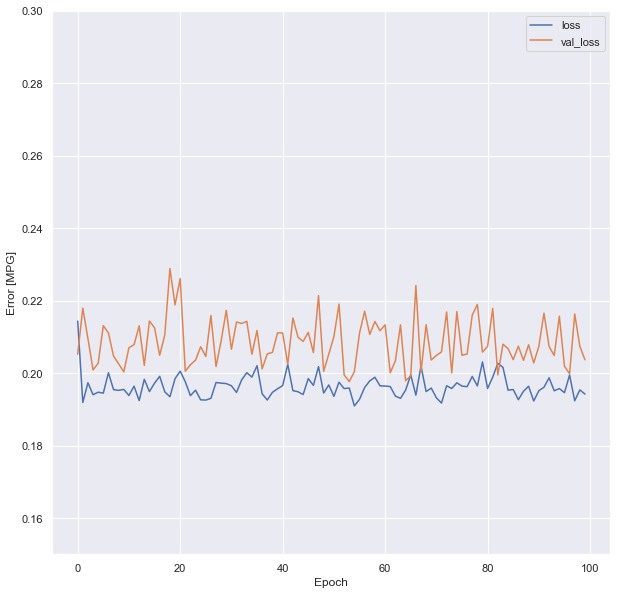

In [191]:
plot_loss(history)

In [192]:
# Collect the results on the test set
test_results = {}

test_results['visibility'] = visibility_model.evaluate(
    test_features['Visibility(mi)'],
    test_labels, verbose=0)

In [193]:
# Visualize model's predictions
x = tf.linspace(0.0, 1, 2)
y = visibility_model.predict(x)

1/1 [==============================] - 0s 65ms/step


In [194]:
def plot_visibility(x, y):
  plt.scatter(train_features['Visibility(mi)'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Visibility(mi)')
  plt.ylabel('Severity')
  plt.legend()

2. Scatter Plot

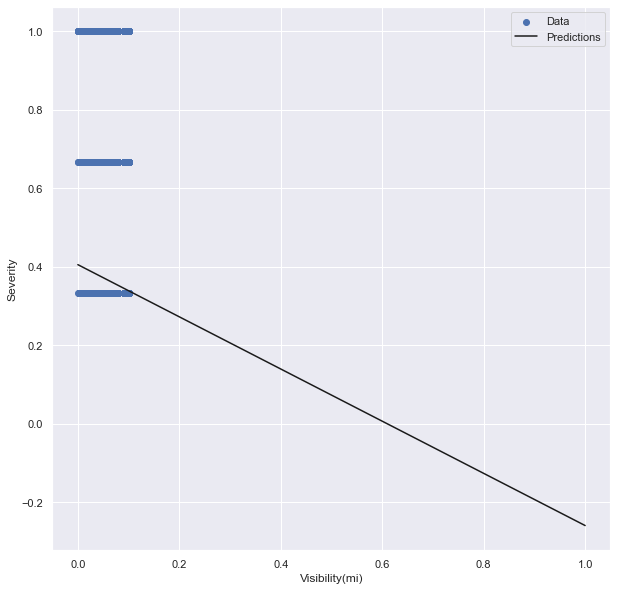

In [195]:
plot_visibility(x, y)

3. Confusion Matrix

In [196]:
correct_d = train_features['Visibility(mi)'].to_numpy()
predicted_d = train_labels.to_numpy()

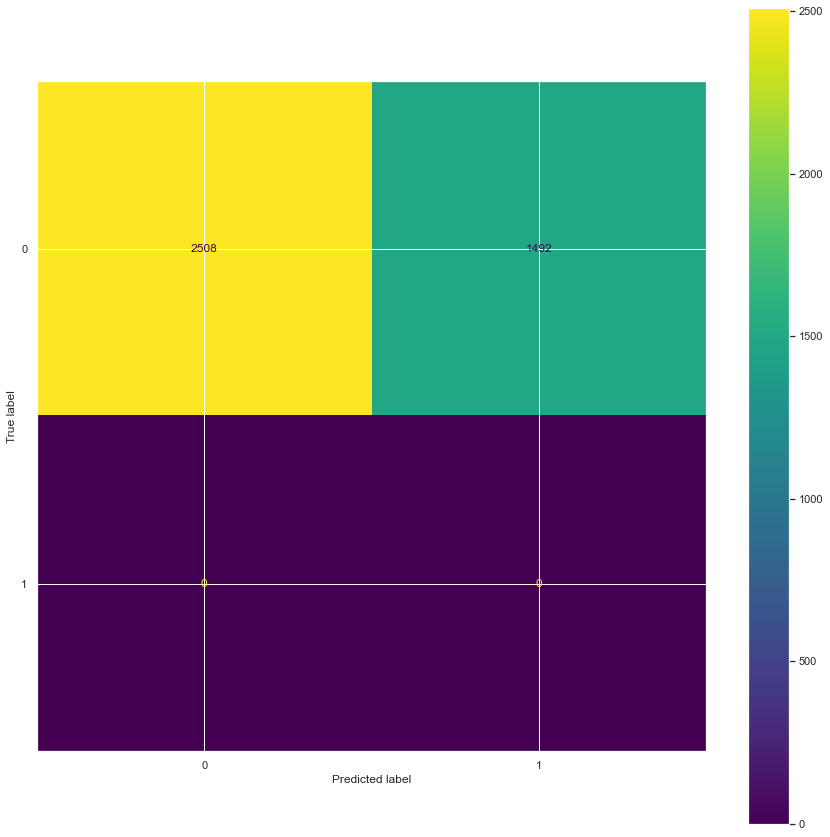

In [197]:
cm = confusion_matrix(np.round(correct_d), np.round(predicted_d))
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax = ax)

Model's score

In [198]:
# Score of basic linear regression
test_results

{'visibility': 0.16311107575893402}

2. Neural Network

In [199]:
# Create model and add layers
model = tf.keras.Sequential()
model.add(Dense(27, input_shape=(None, 10, 27), activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [200]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [201]:
# Train model
history = model.fit(train_features, train_labels, epochs=8, batch_size=10)

Epoch 1/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6886 - accuracy: 0.1315
Epoch 2/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6840 - accuracy: 0.1260
Epoch 3/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6824 - accuracy: 0.1355
Epoch 4/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6815 - accuracy: 0.1343
Epoch 5/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6807 - accuracy: 0.1332
Epoch 6/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6799 - accuracy: 0.1357
Epoch 7/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6793 - accuracy: 0.1373
Epoch 8/8
400/400 [==============================] - 1s 1ms/step - loss: 0.6785 - accuracy: 0.1380


In [202]:
# Model accuracy
accuracy = model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 1ms/step - loss: 0.6825 - accuracy: 0.1060


In [203]:
# Predictions
predictions = model.predict(test_features)
predictions

32/32 [==============================] - 0s 951us/step


array([[0.48253474],
       [0.4638808 ],
       [0.6261442 ],
       [0.5630312 ],
       [0.4510479 ],
       [0.5260546 ],
       [0.45396736],
       [0.5471346 ],
       [0.4974619 ],
       [0.45635524],
       [0.45759678],
       [0.40268272],
       [0.40723434],
       [0.4177077 ],
       [0.6750081 ],
       [0.40834472],
       [0.5683184 ],
       [0.41141236],
       [0.40247905],
       [0.45757937],
       [0.3820457 ],
       [0.53634286],
       [0.40582561],
       [0.38407168],
       [0.38538295],
       [0.41111574],
       [0.38305926],
       [0.40646482],
       [0.4265494 ],
       [0.40042716],
       [0.41402188],
       [0.4171755 ],
       [0.6776146 ],
       [0.38341627],
       [0.38322133],
       [0.59497815],
       [0.38065806],
       [0.6771217 ],
       [0.4659679 ],
       [0.41354346],
       [0.4058671 ],
       [0.41951287],
       [0.40613046],
       [0.45331112],
       [0.4059675 ],
       [0.3852412 ],
       [0.39710164],
       [0.504

Neural Network Visualization

1. Loss Statistics

In [204]:
# Loss statistics
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,epoch
3,0.681543,0.13425,3
4,0.680696,0.13325,4
5,0.679901,0.13575,5
6,0.679301,0.13725,6
7,0.678544,0.13800,7


2. Loss plot

KeyError: 'val_loss'

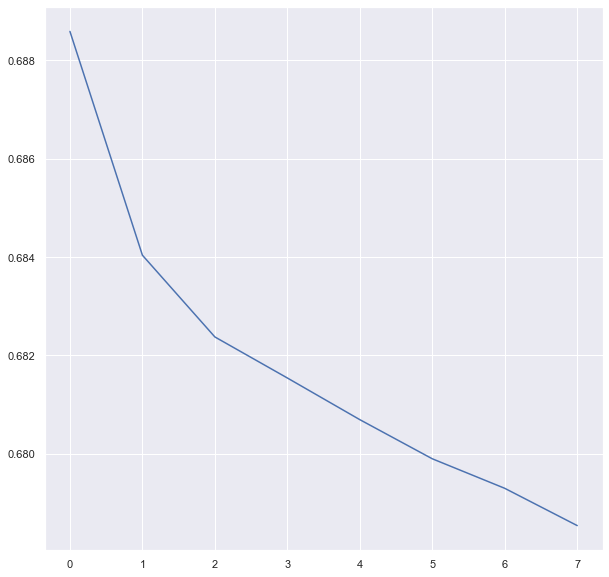

In [205]:
plot_loss(history)

3. Confusion Matrix

In [217]:
correct_d = test_labels.to_numpy()
predicted_d = predictions

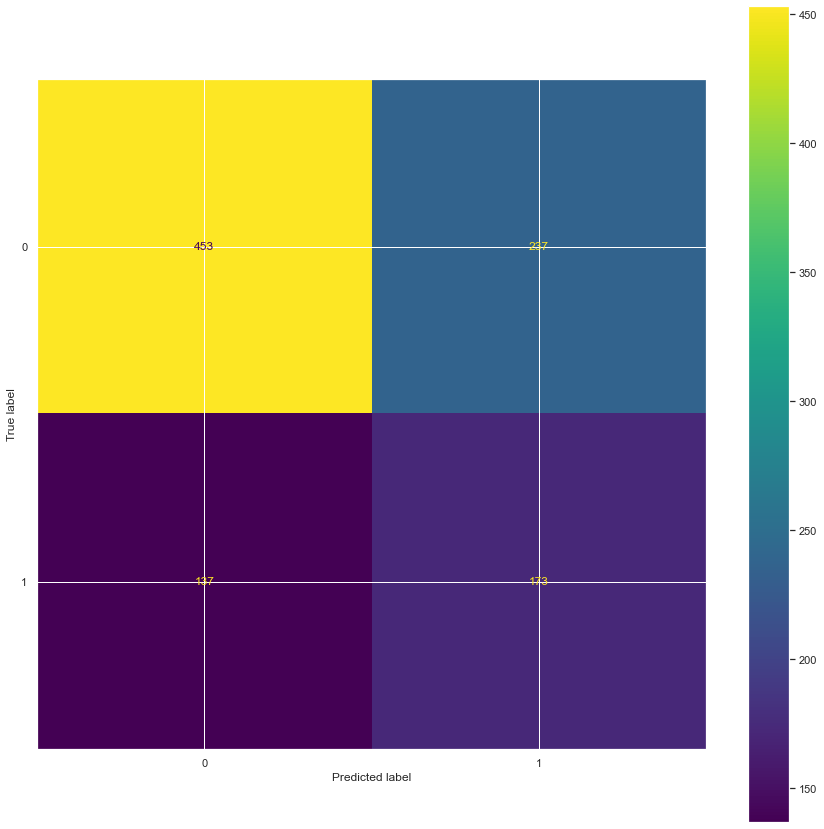

In [218]:
cm = confusion_matrix(np.round(correct_d), np.round(predicted_d))
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax = ax)

3. Linear Least Squares Regression

In [219]:
# Features and labels
sess = tf.compat.v1.Session()
x_vals = train_features['Temperature(F)']
y_vals = train_labels


In [220]:
# Transpose 
x_vals_column = np.transpose(np.matrix(x_vals))

# Bias
ones_column = np.transpose(np.matrix(np.repeat(1, repeats=4000)))
X = np.column_stack((x_vals_column, ones_column))

# Transpose
Y = np.transpose(np.matrix(y_vals))


In [221]:
# Make labels and features constant
X_tensor = tf.constant(X)
Y_tensor = tf.constant(Y)


In [222]:
# Mathematic formula
tX_X = tf.matmul(tf.transpose(X_tensor), X_tensor)
tX_X_inv = tf.linalg.inv(tX_X)
product = tf.matmul(tX_X_inv, tf.transpose(X_tensor))
A = tf.matmul(product, Y_tensor)

In [223]:
# Line slope and intercept
m_slope = A[0][0]
b_intercept = A[1][0]
print('slope (m): ' + str(m_slope))
print('intercept (b): ' + str(b_intercept))

slope (m): tf.Tensor(-0.007918163856334181, shape=(), dtype=float64)
intercept (b): tf.Tensor(0.5217788759929841, shape=(), dtype=float64)


In [224]:
# Best fit
best_fit = []
for i in x_vals:
 best_fit.append(m_slope * i + b_intercept)


Least Squares Regression Visualization

1. Regression Line Plot

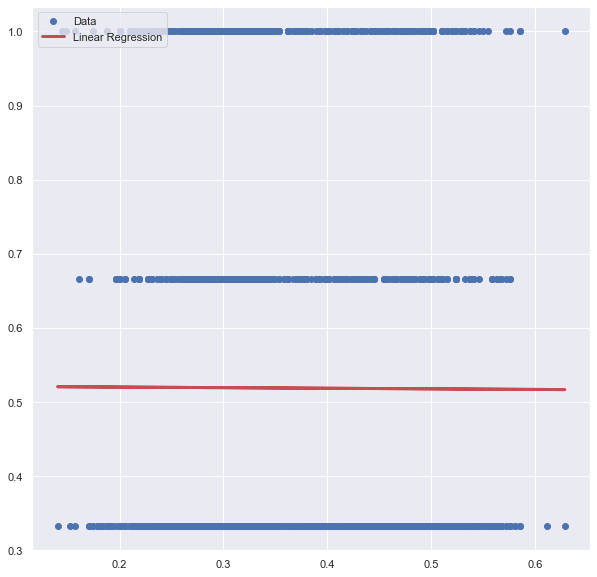

In [225]:
plt.plot(x_vals, y_vals, 'o', label='Data')
plt.plot(x_vals, best_fit, 'r-', label='Linear Regression', linewidth=3)
plt.legend(loc='upper left')
plt.show()


2. Confution Matrix

In [226]:
correct_d = train_features['Temperature(F)'].to_numpy()
predicted_d = train_labels.to_numpy()

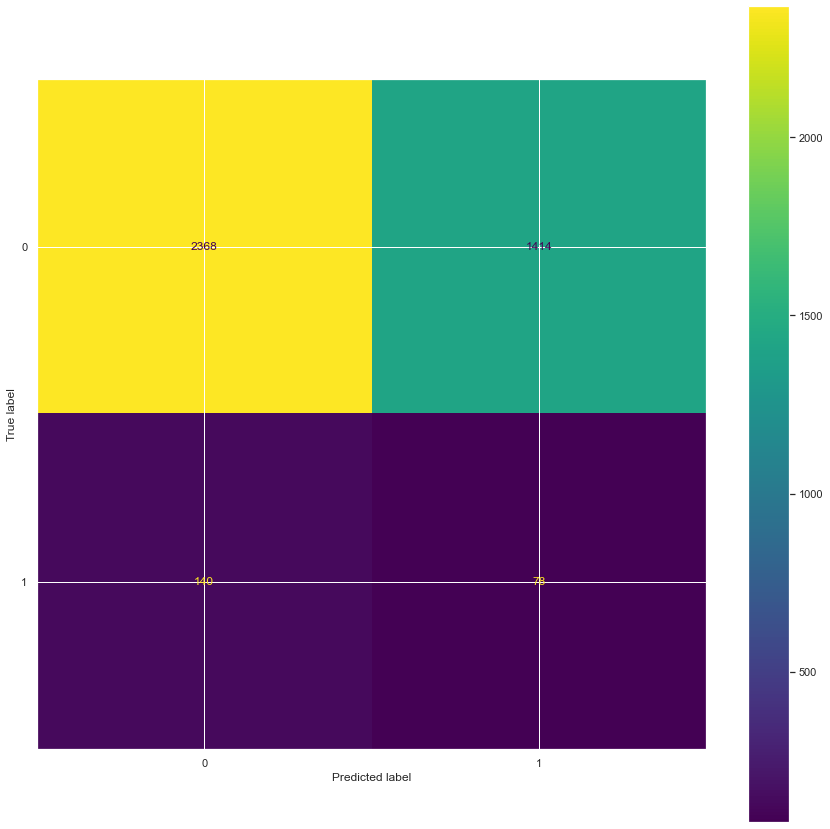

In [227]:
cm = confusion_matrix(np.round(correct_d), np.round(predicted_d))
cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax = ax)